# A Performance Indicator for Position and Shape Recovery

Three aspects are important when one wants to evaluate the quality of reconstruction accomplished by an algorithm designed for EISP: location detection, shape recovery, and contrast estimation. Many indicators are based on the contrast estimation, which evaluate location and shape indirectly. But it would be helpful if specific indicators were designed for these two aspects.

In this notebook, I introduce two indicators designed to evaluate the accuracy of localization and shape recovery. First, I define a single test which will be used to demonstrate both indicators. Then I will present the implementation of both indicators.

## Test Parameters

The test is set with the following parameters:

* Incident field wavelength ($\lambda_b$): 1 (m)
* Incident field magnitude ($E_0$): 1 (V/m)
* Number of sources ($N_S$): 25
* Background relative permittivity: 1
* Observation radius ($R_O$): 6 $\lambda_b$
* Number of measurements ($N_M$): 25
* Image domain length ($L_x$, $L_y$): 4 $\lambda_b$
* Ground-truth image resolution: 100 $\times$ 100 (pixels)
* Noise level: 1 (%/sample)
* Scatterer contrast: 1
* Scatterer radius: $\lambda_b$

The Born Iterative Method will be used to solve this problem. Here are the algorithm's parameters:

* Recovery resolution: 50$\times$50 (pixels)
* Tikhonov parameter ($\alpha$): 0.1
* Iterations: 3

Check out the result below:

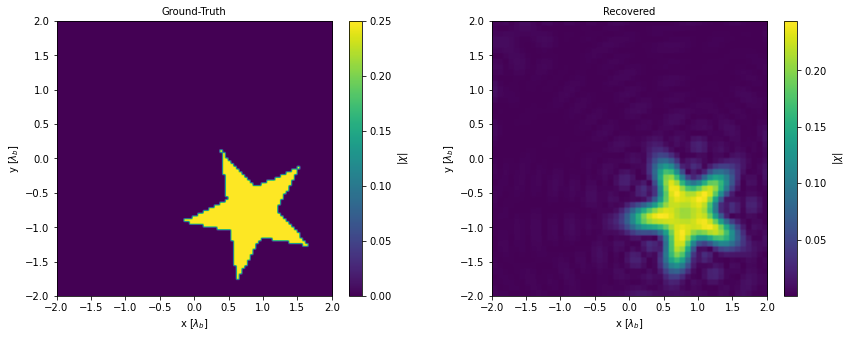

In [1]:
# Import modules
import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom
import richmond as ric
import bim
import regularization as reg
import stopcriteria as stp


# Build configuration object
config = cfg.Configuration(name='cfg_test',
                           wavelength=1.,
                           wavelength_unit=True,
                           number_measurements=25,
                           number_sources=25,
                           image_size=[4., 4.],
                           observation_radius=6.,
                           background_permittivity=1.,
                           magnitude=1.,
                           perfect_dielectric=True)

# Build input data object
inputdata = ipt.InputData(name='ipt_test',
                          configuration=config,
                          resolution=(100, 100),
                          noise=1.,
                          indicators=[rst.RESIDUAL_NORM_ERROR])

# Draw figure
inputdata.rel_permittivity, _ = draw.star5(
    1., # radius
    axis_length_x=config.Lx,
    axis_length_y=config.Ly,
    resolution=inputdata.resolution,
    background_rel_permittivity=inputdata.configuration.epsilon_rb,
    object_rel_permittivity=(.25+1)*inputdata.configuration.epsilon_rb,
    center=[-.8, .8],
    rotate=25
)

# Solve forward problem
_ = mom.MoM_CG_FFT().solve(inputdata, PRINT_INFO=False,
                           COMPUTE_SCATTERED_FIELD=True,
                           SAVE_INTERN_FIELD=False)

# Build object
method = bim.BornIterativeMethod(mom.MoM_CG_FFT(),
                                 reg.Tikhonov(reg.TIK_FIXED, parameter=0.1),
                                 stp.StopCriteria(max_iterations=3))


# Run the method
result = method.solve(inputdata, ric.Richmond(config, (50, 50), state=False),
                      print_info=False)

# Plot recovered map
result.plot_map(show=True, groundtruth=inputdata)

The algorithm as able to locate the scatterer, recover its shape, and make a good estimation of the contrast. But how good the retrievement of position and shape?

## Position accuracy ($\zeta_P$)

I decided to define the position accuracy indicator based on a threshold proccess. The threshold is defined as the half of the contrast range of the recovered image. Then the center of each scatterer is defined as the average of its coordinates. The indicator is defined according to the radius between the two centers.

See below:

In [2]:
import numpy as np

# Compute contrast
Xo = inputdata.rel_permittivity/config.epsilon_rb  - 1
Xr = result.rel_permittivity/config.epsilon_rb - 1

# Threshold
threshold = np.amin(np.abs(Xr)) + .5*(np.amax(np.abs(Xr))-np.amin(np.abs(Xr)))

# Threshold the image
masko = np.zeros(Xo.shape, dtype=bool)
maskr = np.zeros(Xr.shape, dtype=bool)
masko[Xo > 0.] = True
maskr[Xr >= threshold] = True

# Coordinates of both figures
xo, yo = np.meshgrid(np.linspace(0, 1, Xo.shape[1]),
                         np.linspace(0, 1, Xo.shape[0]))
xr, yr = np.meshgrid(np.linspace(0, 1, Xr.shape[1]),
                         np.linspace(0, 1, Xr.shape[0]))

# Centers
xco = np.sum(masko*xo)/np.sum(masko)
yco = np.sum(masko*yo)/np.sum(masko)
xcr = np.sum(maskr*xr)/np.sum(maskr)
ycr = np.sum(maskr*yr)/np.sum(maskr)

# Indicator computation
zeta_p = np.sqrt((xco-xcr)**2 + (yco-ycr)**2)*100

The indicator may be applied even when scatterer with holes. When multiple scatterers are considered, the indicator can also be applied. But, in this case, it measures the error in the center of the scatterer distribution.

One may ask why I defined the threshold based on the recovered image and not on the ground-truth one. The reason is that, doing this, the quality of position will not depend on how good the contrast estimation is. An algorithm may find a scatterer with a lower contrast but in the correct position. And I want to be able to cover these cases.

You should note that the unit is (%). The metric indicates the positioning error in percentage values with reference to the image dimensions.

## Shape Accuracy ($\zeta_S$)

To quantify how good was the retrievement of the position, I make use of [Scikit-Image](https://scikit-image.org/) library which implements the *Marching Squares* algorithm. This algorithm finds the contours of figures in the image. Let's apply the algorithm to find the contour of the scatterer in both figures:

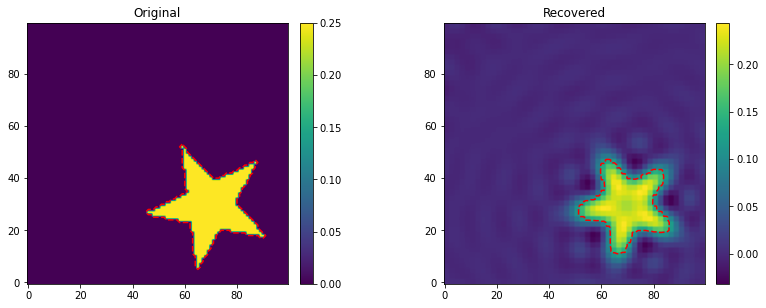

In [3]:
# Import Scikit-Image
from skimage import measure
from matplotlib import pyplot as plt

# Find contour again
co = measure.find_contours(Xo, .0, fully_connected='high')
cr = measure.find_contours(Xr, threshold)

# Plot results
fig, axis = plt.subplots(ncols=2, figsize=[2*6.4, 4.8])
fig.subplots_adjust(wspace=.4)

img = axis[0].imshow(Xo, origin='lower')
axis[0].plot(co[0][:, 1], co[0][:, 0], '--r')
axis[0].set_title('Original')
fig.colorbar(img, ax=axis[0], fraction=0.046, pad=0.04)

img = axis[1].imshow(Xr, origin='lower')
for i in range(len(cr)):
    axis[1].plot(cr[i][:, 1], cr[i][:, 0], '--r')
axis[1].set_title('Recovered')
fig.colorbar(img, ax=axis[1], fraction=0.046, pad=0.04)

plt.show()

You should note that I used the same threshold definition as I used before. After finding the contour, I wish to eliminate the impact of position error. Then, I will repeat the same calculation to centralize both images:

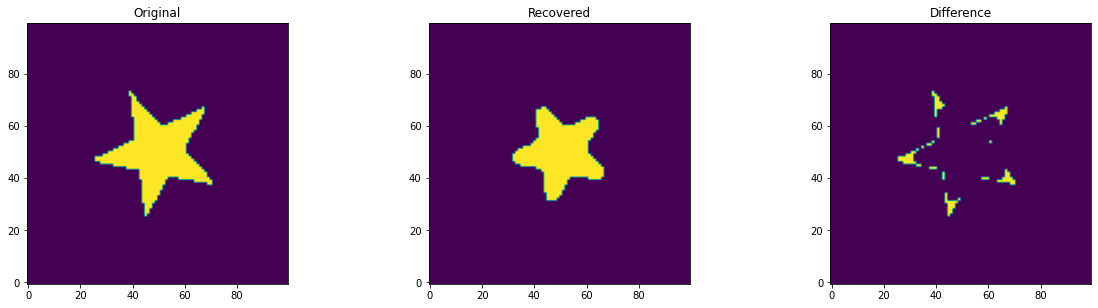

In [4]:
# Converting scale
for i in range(len(cr)):
    cr[i][:, 1] = Xo.shape[1]*cr[i][:, 1]/Xr.shape[1]
    cr[i][:, 0] = Xo.shape[0]*cr[i][:, 0]/Xr.shape[0]

# Threshold process
masko = np.zeros(Xo.shape, dtype=bool)
maskr = np.zeros(Xr.shape, dtype=bool)
masko[Xo > 0] = True
maskr[Xr >= threshold] = True

# Compute coordinates
xo, yo = np.meshgrid(np.arange(0, Xo.shape[1]), np.arange(0, Xo.shape[0]))
xr, yr = np.meshgrid(np.linspace(0, Xo.shape[1]-1, Xr.shape[1]),
                     np.linspace(0, Xo.shape[0]-1, Xr.shape[0]))

# Compute the center
xco = np.sum(masko*Xo*xo)/np.sum(masko*Xo)
yco = np.sum(masko*Xo*yo)/np.sum(masko*Xo)
xcr = np.sum(maskr*Xr*xr)/np.sum(maskr*Xr)
ycr = np.sum(maskr*Xr*yr)/np.sum(maskr*Xr)

# Ground-truth contour coordinates centralization
for i in range(len(co)):
    co[i][:, 0] = co[i][:, 0]-yco+Xo.shape[0]/2
    co[i][:, 1] = co[i][:, 1]-xco+Xo.shape[1]/2

# Recovered contour coordinates centralization
for i in range(len(cr)):
    cr[i][:, 0] = cr[i][:, 0]-ycr+Xo.shape[0]/2
    cr[i][:, 1] = cr[i][:, 1]-xcr+Xo.shape[1]/2

# Set new figures
masko = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(co)):
    maskt = measure.grid_points_in_poly(Xo.shape, co[i])
    counter[maskt] += 1
masko[np.mod(counter, 2) == 1] = True

maskr = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(cr)):
    maskt = measure.grid_points_in_poly(Xo.shape, cr[i])
    counter[maskt] += 1
maskr[np.mod(counter, 2) == 1] = True

# Xor operation
diff = np.logical_xor(masko, maskr)

# Plot results
fig, axis = plt.subplots(ncols=3, figsize=[3*6.4,4.8])
fig.subplots_adjust(wspace=.5)
axis[0].imshow(masko, origin='lower')
axis[0].set_title('Original')
axis[1].imshow(maskr, origin='lower')
axis[1].set_title('Recovered')
axis[2].imshow(diff, origin='lower')
axis[2].set_title('Difference')

plt.show()


Then, the metric is defined as the proportion between the difference area and the area of the scatterer in the ground-truth image:

In [5]:
# Area of the difference
area_diff = np.sum(diff)/np.sum(masko)*100
print('Shape error: %.2f %%' % area_diff)

Shape error: 16.34 %


Again, the unit is (%).

Now, I just want to show an example when the algorithms fails to recover the center of the image:

Execution time: 12.68 [sec]
Method: Born Iterative Method
Alias: bim
Input Data: ipt_test
Discretization: Richmond Method (50x50)
Foward Solver: Method of Moments - CG-FFT
Number of iterations: 5000, Tolerance level: 1.000e-03
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e-01
Stop Criteria
Maximum number of iterations: 3
Iteration: 1 -  Residual norm: 7.761e-01,
Iteration: 2 -  Residual norm: 6.064e-01,
Iteration: 3 -  Residual norm: 4.733e-01,


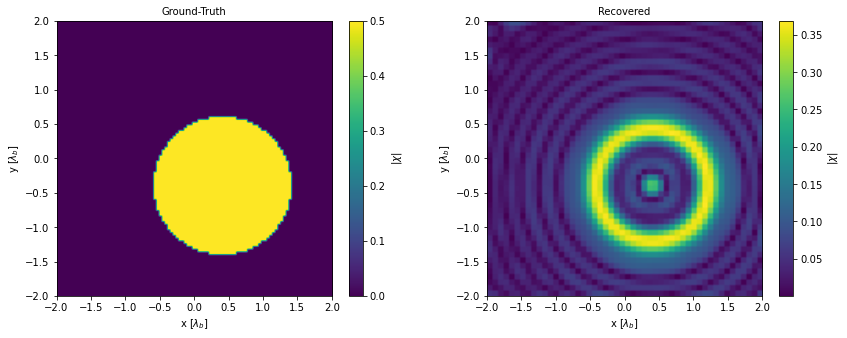

In [6]:
# Draw figure
inputdata.rel_permittivity, _ = draw.circle(
    1.,
    axis_length_x=config.Lx,
    axis_length_y=config.Ly,
    resolution=inputdata.resolution,
    background_rel_permittivity=inputdata.configuration.epsilon_rb,
    object_rel_permittivity=(0.5+1)*inputdata.configuration.epsilon_rb,
    center=[-.4, .4],
)

# Solve forward problem
_ = mom.MoM_CG_FFT().solve(inputdata, PRINT_INFO=True,
                           COMPUTE_SCATTERED_FIELD=True,
                           SAVE_INTERN_FIELD=False)

# Build object
method = bim.BornIterativeMethod(mom.MoM_CG_FFT(),
                                 reg.Tikhonov(reg.TIK_FIXED, parameter=1e-1),
                                 stp.StopCriteria(max_iterations=3))


# Run the method
result = method.solve(inputdata, ric.Richmond(config, (50, 50), state=False),
                      print_info=True)

# Plot recovered map
result.plot_map(show=True, groundtruth=inputdata)

Now, if we run the same approach for this new result:

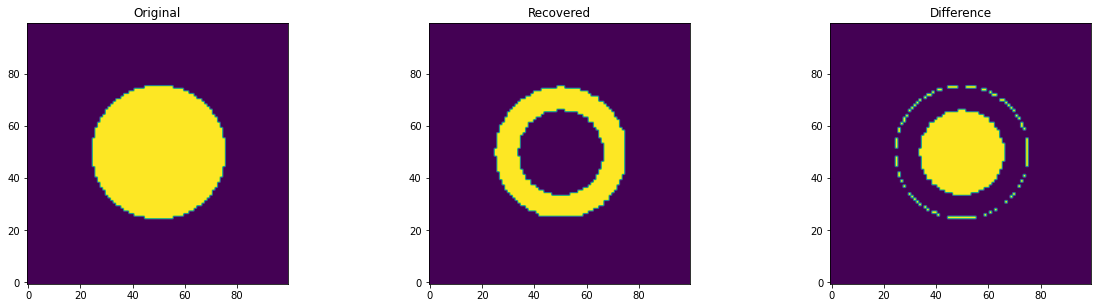

Shape error: 44.73 %


In [7]:
Xo = inputdata.rel_permittivity/config.epsilon_rb  - 1
Xr = result.rel_permittivity/config.epsilon_rb - 1

co = measure.find_contours(Xo, 0., fully_connected='high')
cr = measure.find_contours(Xr, 0.)

threshold = (np.amin(np.abs(Xr)) + .5*(np.amax(np.abs(Xr))-np.amin(np.abs(Xr))))
cr = measure.find_contours(Xr, threshold)

# Converting scale
for i in range(len(cr)):
    cr[i][:, 1] = Xo.shape[1]*cr[i][:, 1]/Xr.shape[1]
    cr[i][:, 0] = Xo.shape[0]*cr[i][:, 0]/Xr.shape[0]

masko = np.zeros(Xo.shape, dtype=bool)
maskr = np.zeros(Xr.shape, dtype=bool)

masko[Xo > 0] = True
maskr[Xr >= threshold] = True

xo, yo = np.meshgrid(np.arange(0, Xo.shape[1]), np.arange(0, Xo.shape[0]))
xr, yr = np.meshgrid(np.linspace(0, Xo.shape[1]-1, Xr.shape[1]),
                     np.linspace(0, Xo.shape[0]-1, Xr.shape[0]))

xco = np.sum(masko*Xo*xo)/np.sum(masko*Xo)
yco = np.sum(masko*Xo*yo)/np.sum(masko*Xo)
xcr = np.sum(maskr*Xr*xr)/np.sum(maskr*Xr)
ycr = np.sum(maskr*Xr*yr)/np.sum(maskr*Xr)

# Centralization
for i in range(len(co)):
    co[i][:, 0] = co[i][:, 0]-yco+Xo.shape[0]/2
    co[i][:, 1] = co[i][:, 1]-xco+Xo.shape[1]/2

# Centralization
for i in range(len(cr)):
    cr[i][:, 0] = cr[i][:, 0]-ycr+Xo.shape[0]/2
    cr[i][:, 1] = cr[i][:, 1]-xcr+Xo.shape[1]/2

masko = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(co)):
    maskt = measure.grid_points_in_poly(Xo.shape, co[i])
    counter[maskt] += 1
masko[np.mod(counter, 2) == 1] = True

maskr = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(cr)):
    maskt = measure.grid_points_in_poly(Xo.shape, cr[i])
    counter[maskt] += 1
maskr[np.mod(counter, 2) == 1] = True
    
# Xor operation
diff = np.logical_xor(masko, maskr)

# Area of the difference
area_diff = np.sum(diff)/np.sum(masko)*100

# Figure
fig, axis = plt.subplots(ncols=3, figsize=[3*6.4,4.8])
fig.subplots_adjust(wspace=.5)
axis[0].imshow(masko, origin='lower')
axis[0].set_title('Original')
axis[1].imshow(maskr, origin='lower')
axis[1].set_title('Recovered')
axis[2].imshow(diff, origin='lower')
axis[2].set_title('Difference')

plt.show()

print('Shape error: %.2f %%' % area_diff)

The indicator might be used with multiples scatterers in the image as well.

## Conclusion

This notebook implements two indicators which are specific for measuring the quality of the location and shape retrievement. Both metrics avoids the impact of the contrast estimation in their calculus. They also may be used with multiple scatterers or when the algorithms fail to recover the middle of the scatterer.